__Particle Filter with Synthetic Beamformer Output__

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import time
import pylab as pl
from IPython import display

In [2]:
def get_synthetic_bf(phi, theta, azimuths, elevations):
    # transform from azimuth/elevation to x/y/z
    lobe_sharpness = 0.1
    lobe_amplitude = 4
    lobe_values = np.zeros([elevations.shape[0],azimuths.shape[0]])
    lobe_values_x = np.zeros([elevations.shape[0],azimuths.shape[0]])
    lobe_values_y = np.zeros([elevations.shape[0],azimuths.shape[0]])
    lobe_values_z = np.zeros([elevations.shape[0],azimuths.shape[0]])
    for i, elev in enumerate(elevations):
        for j, azim in enumerate(azimuths):
            lobe_values_x[i,j] = np.sin(elev)*np.cos(azim)
            lobe_values_y[i,j] = np.sin(elev)*np.sin(azim)
            lobe_values_z[i,j] = np.cos(elev)
    lobe_values = lobe_values_x*np.sin(theta)*np.cos(phi) + \
                  lobe_values_y*np.sin(theta)*np.sin(phi) + \
                  lobe_values_z*np.cos(theta)
    lobe_values = lobe_amplitude*np.exp(lobe_sharpness*(lobe_values-1))
    min_lobe = np.min(lobe_values)
    max_lobe = np.max(lobe_values)
    lobe_values = (lobe_values-min_lobe)/(max_lobe-min_lobe)
    return lobe_values

def rad_to_deg(rad):
    return rad*180.0/np.pi

def deg_to_rad(deg):
    return deg*np.pi/180.0

Test Synthetic Beamformer:

(0, 180)

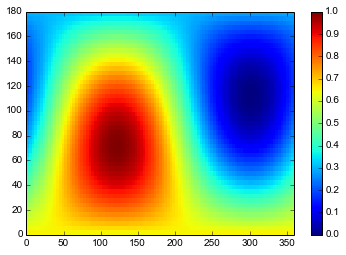

In [221]:
azimuths = np.linspace(0,360,100)*np.pi/180.0
elevations = np.linspace(0,180,50)*np.pi/180.0
bf_out = get_synthetic_bf(phi=120*np.pi/180.0, theta=70*np.pi/180.0, azimuths=azimuths, elevations=elevations)

# heatmap of synthetic beamformer output
plt.pcolor(azimuths*180/np.pi,elevations*180/np.pi,bf_out)
plt.colorbar()
axes = plt.gca()
axes.set_xlim([0,360])
axes.set_ylim([0,180])

Sample Uniformly Over Sphere and Find Spherical Mean:

In [4]:
def sphere_uniform(num_points):
    u = np.random.uniform(size=num_points)
    v = np.random.uniform(size=num_points)
    phi = rad_to_deg(2*np.pi*u)
    theta = rad_to_deg(np.arccos(2*v - 1))
    weights = np.ones(num_points)/num_points
    return phi, theta, weights

def spherical_mean_particles(particles_phi, particles_theta):
    mean_phi = np.arctan2(np.mean(np.sin(deg_to_rad(particles_phi))), \
                        np.mean(np.cos(deg_to_rad(particles_phi))))
    mean_phi = rad_to_deg(mean_phi)
    if mean_phi < 0:
        mean_phi += 360
    elif mean_phi > 360:
        mean_phi -= 360
    mean_theta = np.arctan2(np.mean(np.sin(deg_to_rad(particles_theta))), \
                          np.mean(np.cos(deg_to_rad(particles_theta))))
    mean_theta = rad_to_deg(mean_theta)
    if mean_theta < 0:
        mean_theta = -mean_theta
    elif mean_theta > 180:
        mean_theta = 360 - mean_theta
    return mean_phi, mean_theta

def spherical_mean_particles_weighted(particles_phi, particles_theta, particles_weights):
    mean_phi = np.arctan2(np.average(np.sin(deg_to_rad(particles_phi)), weights=particles_weights), \
                        np.average(np.cos(deg_to_rad(particles_phi)), weights=particles_weights))
    mean_phi = rad_to_deg(mean_phi)
    if mean_phi < 0:
        mean_phi += 360
    elif mean_phi > 360:
        mean_phi -= 360
    mean_theta = np.arctan2(np.average(np.sin(deg_to_rad(particles_theta)), weights=particles_weights), \
                          np.average(np.cos(deg_to_rad(particles_theta)), weights=particles_weights))
    mean_theta = rad_to_deg(mean_theta)
    if mean_theta < 0:
        mean_theta = -mean_theta
    elif mean_theta > 180:
        mean_theta = 360 - mean_theta
    return mean_phi, mean_theta

(0, 180)

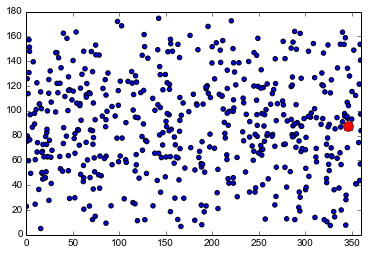

In [266]:
phi, theta, weights = sphere_uniform(num_points=500)
mean_phi, mean_theta = spherical_mean_particles(particles_phi=phi, particles_theta=theta)

# plot spherically uniform particles, and spherical mean of particles
plt.scatter(phi, theta)
plt.plot(mean_phi, mean_theta, 'ro', markersize=10)
axes = plt.gca()
axes.set_xlim([0,360])
axes.set_ylim([0,180])

Sequential Importance Sampling using Synthetic Beamformer Output:

In [267]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

def sequential_importance_sampling(importance, importance_phis, importance_thetas, \
                                   particles_phi, particles_theta, particles_weights):
    # find index closest to each sample position
    closest_phi_idxs = find_closest(rad_to_deg(importance_phis), particles_phi)
    closest_theta_idxs = find_closest(rad_to_deg(importance_thetas), particles_theta)
    # perfom importance sampling, re-weighting each particle
    particles_weights *= importance[closest_theta_idxs, closest_phi_idxs]
    particles_weights /= np.sum(particles_weights)
    return particles_weights

(0, 180)

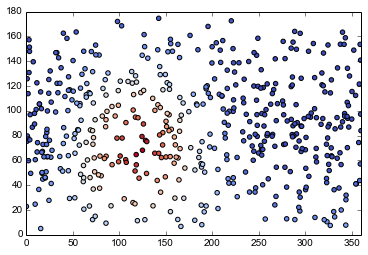

In [268]:
weights = sequential_importance_sampling(importance=bf_out**3, importance_phis=azimuths, importance_thetas=elevations,\
                                        particles_phi=phi, particles_theta=theta, particles_weights=weights)

# plot new particle weights
plt.scatter(phi, theta, c=weights, cmap=plt.cm.coolwarm)
axes = plt.gca()
axes.set_xlim([0,360])
axes.set_ylim([0,180])

Particle Resampling and Dispersion (since we do not have a predict step):

In [171]:
# resample - new particles are distributed in density according to weights of old particles
# weights of new particles are normalized but are proportional to weights of old particles
def multinomal_resample(particles_phi, particles_theta, particles_weights):
    cumulative_sum = np.cumsum(particles_weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    idxs = np.searchsorted(cumulative_sum, np.random.uniform(size=particles_weights.shape[0]))
    # resample according to indexes
    particles_phi[:] = particles_phi[idxs]
    particles_theta[:] = particles_theta[idxs]
    particles_weights[:] = particles_weights[idxs]
    particles_weights /= np.sum(particles_weights)

# resample - new particles are distributed in density according to weights of old particles
# weights of new particles are normalized and equal
def multinomal_resample_reweight(particles_phi, particles_theta, particles_weights):
    cumulative_sum = np.cumsum(particles_weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    idxs = np.searchsorted(cumulative_sum, np.random.uniform(size=particles_weights.shape[0]))
    # resample according to indexes
    particles_phi[:] = particles_phi[idxs]
    particles_theta[:] = particles_theta[idxs]
    particles_weights[:] = np.ones(particles_weights.shape[0])/particles_weights.shape[0]
    
def systematic_resample(particles_phi, particles_theta, particles_weights):
    N = len(particles_weights)
    # make N subdivisions, and choose positions with a consistent random offset
    positions = (np.random.random() + np.arange(N)) / N
    idxs = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(particles_weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            idxs[i] = j
            i += 1
        else:
            j += 1
    particles_phi[:] = particles_phi[idxs]
    particles_theta[:] = particles_theta[idxs]
    particles_weights[:] = particles_weights[idxs]
    particles_weights /= np.sum(particles_weights)

# randomly move particles in azimuth and elevation according to normal distribution
def disperse_particles(particles_phi, particles_theta, phi_std, theta_std):
    rand_phi = np.random.normal(0, phi_std, particles_phi.shape[0])
    rand_theta = np.random.normal(0, theta_std, particles_theta.shape[0])
    particles_phi += rand_phi
    particles_theta += rand_theta
    particles_phi[particles_phi<0] += 360.0
    particles_phi[particles_phi>360] -= 360.0
    particles_theta[particles_theta<0] = -particles_theta[particles_theta<0]
    particles_theta[particles_theta>180] = 360.0 - particles_theta[particles_theta>180]

(0, 180)

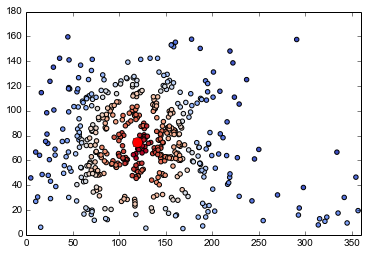

In [269]:
systematic_resample(particles_phi=phi, particles_theta=theta, particles_weights=weights)
disperse_particles(particles_phi=phi, particles_theta=theta, phi_std=3, theta_std=3)
mean_phi, mean_theta = spherical_mean_particles(particles_phi=phi, particles_theta=theta)

# plot resampled particles
plt.scatter(phi, theta, c=weights, cmap=plt.cm.coolwarm)
plt.plot(mean_phi, mean_theta, 'ro', markersize=10)
axes = plt.gca()
axes.set_xlim([0,360])
axes.set_ylim([0,180])

Simple Dynamic Plot:

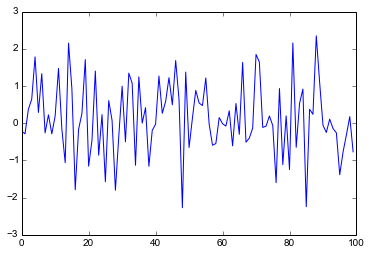

In [11]:
for i in range(10):
    pl.plot(pl.randn(100))
    display.display(pl.gcf())
    display.clear_output(wait=True)
    if i != 9:
        pl.cla() #clear on each plot
    time.sleep(0.5)

Several Rounds of Creating New Importances and Performing Sequential Importance Resampling:

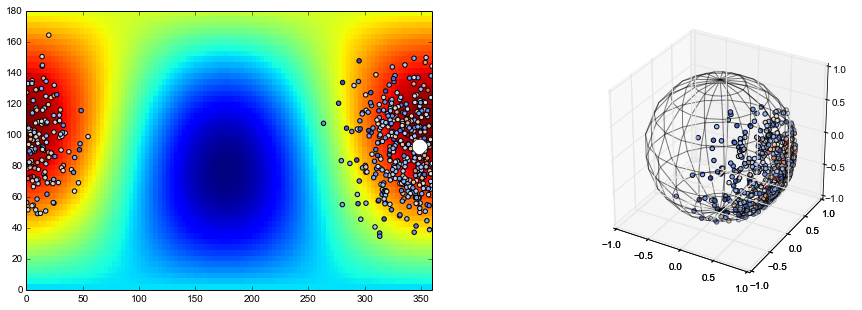

In [271]:
phi, theta, weights = sphere_uniform(num_points=500)
    
azimuths = np.linspace(0,360,100)*np.pi/180.0
elevations = np.linspace(0,180,50)*np.pi/180.0
num_steps = 50
azim_innov = np.linspace(45, 355, num_steps)*np.pi/180.0
elev_innov = (np.random.uniform(size=num_steps)*60 + 60)*np.pi/180.0

fig = pl.figure(figsize=(16,5))
ax3d = fig.add_subplot(1, 2, 2, projection='3d')
ax2d = fig.add_subplot(1, 2, 1)
ax3d.set_aspect("equal")
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)

for i in range(num_steps):
    ax2d.cla()
    ax3d.cla()
    
    importance = get_synthetic_bf(phi=azim_innov[i], theta=elev_innov[i], \
                                  azimuths=azimuths, elevations=elevations)
    
    # plot importance as heatmap
    ax2d.pcolor(azimuths*180.0/np.pi,elevations*180.0/np.pi,importance)
    ax2d.set_xlim([0,360])
    ax2d.set_ylim([0,180])
    display.display(pl.gcf())
    display.clear_output(wait=True)
    
    weights = sequential_importance_sampling(importance=importance**4, importance_phis=azimuths, \
                                             importance_thetas=elevations, particles_phi=phi, \
                                             particles_theta=theta, particles_weights=weights)
    
    systematic_resample(particles_phi=phi, particles_theta=theta, particles_weights=weights)
    disperse_particles(particles_phi=phi, particles_theta=theta, phi_std=15, theta_std=15)
    mean_phi, mean_theta = spherical_mean_particles_weighted(particles_phi=phi, particles_theta=theta, \
                                                             particles_weights=weights)
    
    # plot resampled particles and mean of particles
    ax2d.scatter(phi, theta, c=weights, cmap=plt.cm.coolwarm)
    ax2d.plot(mean_phi, mean_theta, 'wo', markersize=15)
    ax2d.set_xlim([0,360])
    ax2d.set_ylim([0,180])
    display.display(pl.gcf())
    display.clear_output(wait=True)
        
    particles_x = np.sin(deg_to_rad(theta))*np.cos(deg_to_rad(phi))
    particles_y = np.sin(deg_to_rad(theta))*np.sin(deg_to_rad(phi))
    particles_z = np.cos(deg_to_rad(theta))

    # plot particles as x,y,z with sphere
    ax3d.plot_wireframe(x, y, z, color=[0,0,0,0.5])
    ax3d.scatter(particles_x, particles_y, particles_z, c=weights, cmap=plt.cm.coolwarm)
    ax3d.set_xlim([-1,1])
    ax3d.set_ylim([-1,1])
    ax3d.set_zlim([-1,1])
    display.display(pl.gcf())
    display.clear_output(wait=True)

Particle Resampling Approaches:

In [167]:
# resample - new particles are distributed in density according to weights of old particles
# weights of new particles are normalized and equal

def multinomal_resample_reweight(particles_phi, particles_theta, particles_weights):
    cumulative_sum = np.cumsum(particles_weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    sel = np.random.random_sample(particles_weights.shape[0])
    idxs = np.searchsorted(cumulative_sum, sel)
    print idxs
    # resample according to indexes
    particles_phi[:] = particles_phi[idxs]
    particles_theta[:] = particles_theta[idxs]
    particles_weights[:] = np.ones(particles_weights.shape[0])/particles_weights.shape[0]
    
def residual_resample_reweight(particles_phi, particles_theta, particles_weights):
    N = len(particles_weights)
    indexes = np.zeros(N, 'i')
    # take int(N*w) copies of each weight, which ensures particles with the
    # same weight are drawn uniformly
    num_copies = (np.floor(N*np.asarray(particles_weights))).astype(int)
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1
    # use multinormal resample on the residual to fill up the rest. This
    # maximizes the variance of the samples
    residual = particles_weights - num_copies     # get fractional part
    residual /= sum(residual)                     # normalize
    cumulative_sum = np.cumsum(residual)
    cumulative_sum[-1] = 1. # avoid round-off errors: ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, np.random.random(N-k))
    print indexes
    particles_phi[:] = particles_phi[indexes]
    particles_theta[:] = particles_theta[indexes]
    particles_weights[:] = np.ones(particles_weights.shape[0])/particles_weights.shape[0]

def stratified_resample_reweight(particles_phi, particles_theta, particles_weights):
    N = len(particles_weights)
    # make N subdivisions, and chose a random position within each one
    positions = (np.random.random(N) + range(N)) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(particles_weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    print indexes
    particles_phi[:] = particles_phi[indexes]
    particles_theta[:] = particles_theta[indexes]
    particles_weights[:] = np.ones(particles_weights.shape[0])/particles_weights.shape[0]

def systematic_resample_reweight(particles_phi, particles_theta, particles_weights):
    N = len(particles_weights)
    # make N subdivisions, and choose positions with a consistent random offset
    positions = (np.random.random() + np.arange(N)) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(particles_weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    print indexes
    particles_phi[:] = particles_phi[indexes]
    particles_theta[:] = particles_theta[indexes]
    particles_weights[:] = np.ones(particles_weights.shape[0])/particles_weights.shape[0]

In [168]:
phi = np.array([44.69087895,  244.48985592,   89.59831651,  115.58886671,  335.4846907,  
                186.32960813,   43.47819794,  186.14408974,   32.25250331,  188.40122328])
theta = np.array([92.18951944,  102.35294754,  136.99002206,  125.06438378,   83.57077185,    
                  7.12422439,   49.06203387,   77.36593171,   17.41408544,   97.19730026])
weights = np.array([2.84357697e-01,   8.14429204e-05,   1.78261857e-02,   5.15294017e-03,
   1.91347220e-01,   4.78005342e-02,   2.96522943e-01,   2.22810975e-05,
   1.56888661e-01,   9.48604674e-08])
#6,0,4,8,5,2,3,1,7,9
#multinomal_resample_reweight(phi, theta, weights)
#residual_resample_reweight(phi, theta, weights)
stratified_resample_reweight(phi, theta, weights)
#systematic_resample_reweight(phi, theta, weights)

[0 0 0 4 4 6 6 6 8 8]
